In [1]:
import equinox as eqx
import jax
import jax.numpy as jnp
from jaxoptics import ScalarField, Gaussian, HermiteGaussian, normalize_power
from jaxoptics import ASProp, Phase, OpticalSequence
import matplotlib.pyplot as plt

In [2]:
print(jax.devices())

[CudaDevice(id=0)]


In [3]:
shape = (512, 512)
ds = (2e-6, 2e-6)
wavelengths = [1.064e-6, 800e-9, 532e-9]

gauss = Gaussian(w0=100e-6)(shape, ds, (0, 100e-6))
hg10 = HermiteGaussian(w0=100e-6, m=1, n=0)(shape, ds, (100e-6,0))
hg11 = HermiteGaussian(w0=100e-6, m=1, n=1)(shape, ds)

u0 = ScalarField(jnp.stack([gauss, hg10, hg11], axis=0), ds, wavelengths)
u0 = normalize_power(u0)

u0.power

Array([0.99999994, 1.        , 1.        ], dtype=float32)

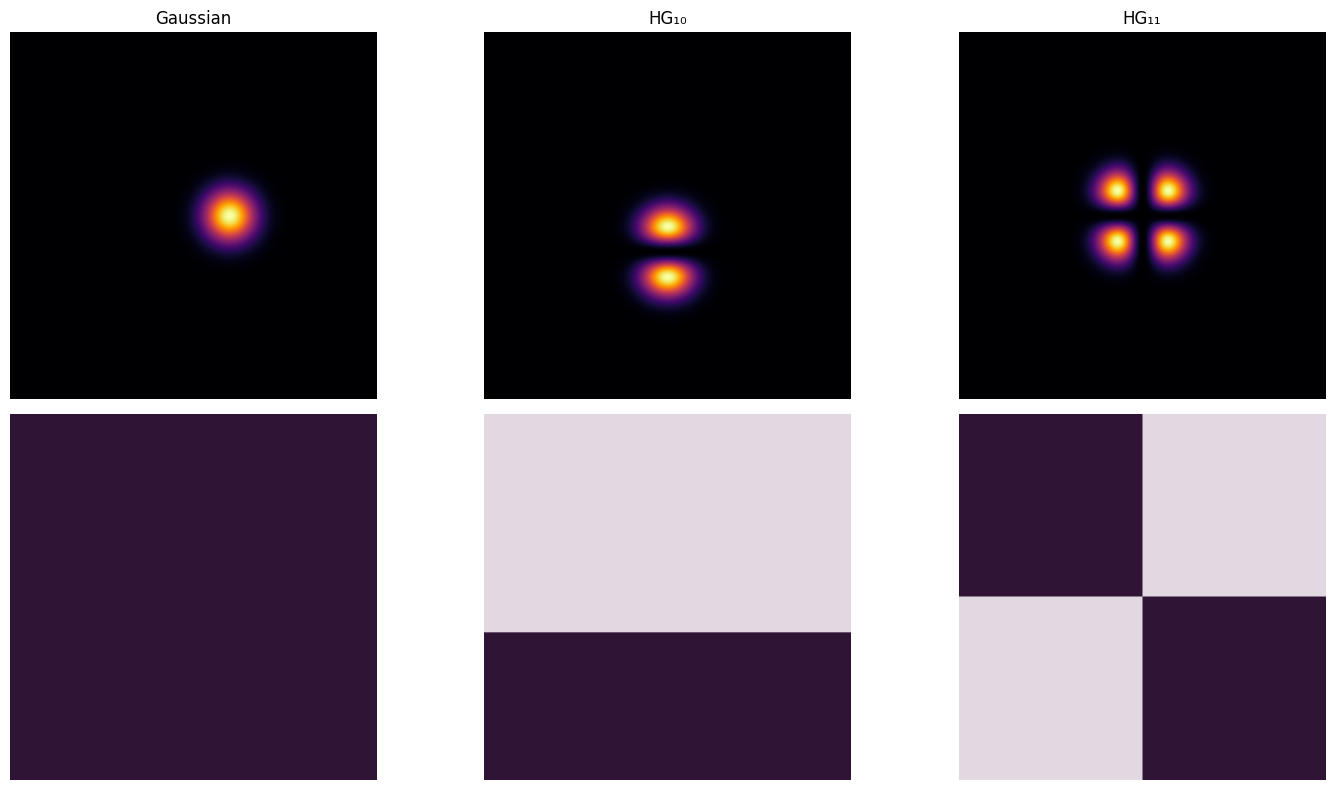

In [4]:
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
titles = ['Gaussian', 'HG₁₀', 'HG₁₁']

for i, title in enumerate(titles):
    axes[0, i].imshow(jnp.abs(u0.electric[i])**2, cmap='inferno')
    axes[0, i].set_title(title)
    axes[0, i].axis('off')
    
    axes[1, i].imshow(jnp.angle(u0.electric[i]), cmap='twilight', vmin=-jnp.pi, vmax=jnp.pi)
    axes[1, i].axis('off')

plt.tight_layout()

In [86]:
phase = Phase(u0, init_fn=lambda x, y: -jnp.pi * (x**2 + y**2) / 1e-6 / 20e-3, trainable=True)

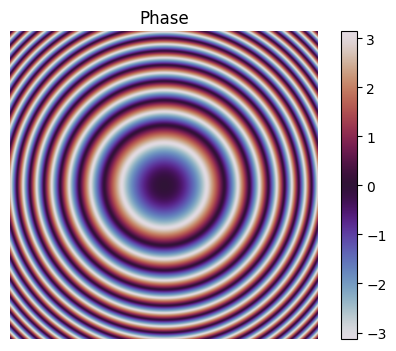

In [87]:
plt.figure(figsize=(6, 4))
plt.imshow(jnp.angle(jnp.exp(1j*phase.phase_mask)), cmap='twilight')
plt.axis('off')
plt.colorbar()
plt.title(f'Phase')
plt.show()

In [88]:
prop_cached = ASProp(u0, z=10e-3, use_cache=True, paraxial=False)
system = OpticalSequence(prop_cached, phase, prop_cached)

In [89]:
uf = eqx.filter_jit(system)(u0)

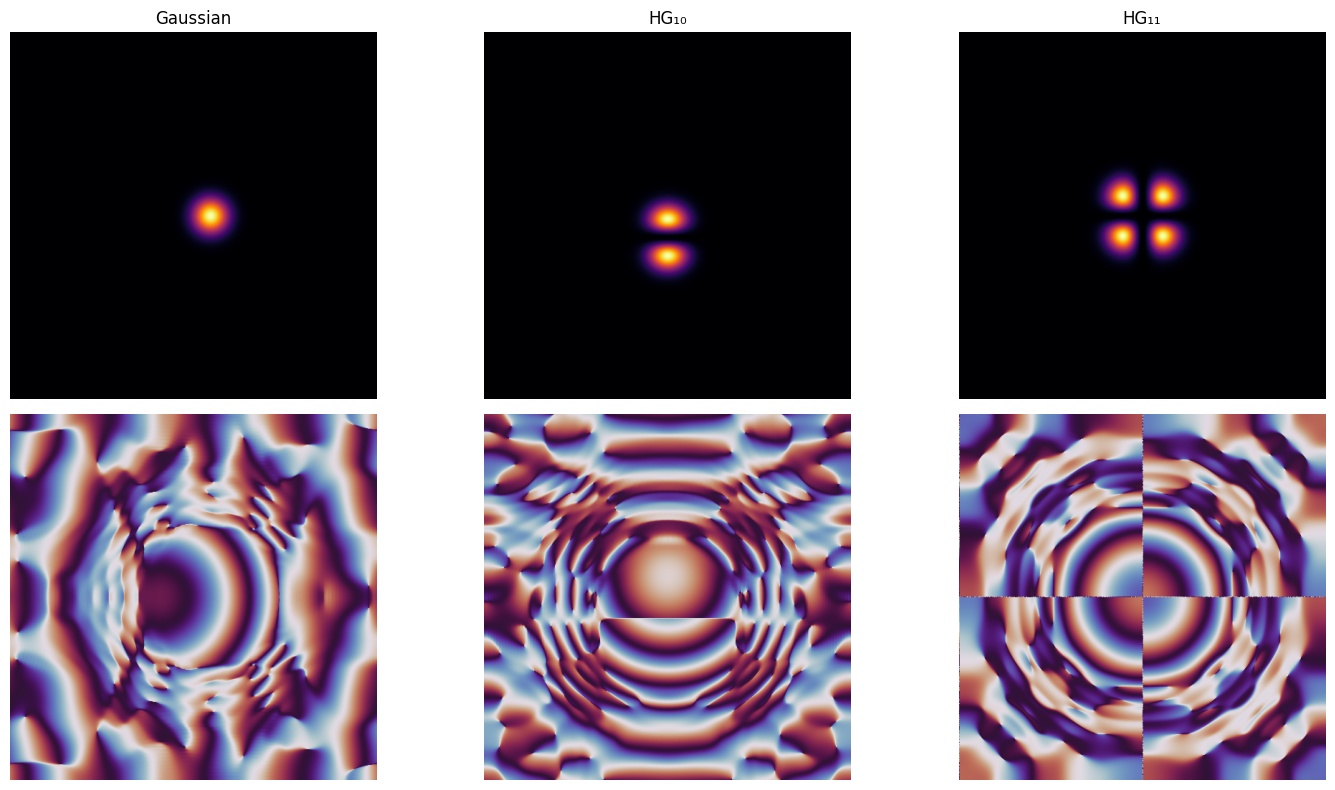

In [90]:
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
titles = ['Gaussian', 'HG₁₀', 'HG₁₁']

for i, title in enumerate(titles):
    axes[0, i].imshow(jnp.abs(uf.electric[i])**2, cmap='inferno')
    axes[0, i].set_title(title)
    axes[0, i].axis('off')
    
    axes[1, i].imshow(jnp.angle(uf.electric[i]), cmap='twilight', vmin=-jnp.pi, vmax=jnp.pi)
    axes[1, i].axis('off')

plt.tight_layout()

In [80]:
@jax.jit
def apply_prop(u):
    return prop_cached(u)

uf = apply_prop(u0)